# T5 Inversion
Generates a T5 Embeddings from input images to be used in [DeepFloyd IF](https://github.com/deep-floyd/IF) 

**Copyright © 2020 [HANS ROETTGER](mailto:oss.roettger@posteo.org)**, distributed under the terms of **[AGPLv3](https://www.gnu.org/licenses/agpl-3.0.html)**.


## Set the path to your T5/Stage_I models, your input images and embedding output here!

In [1]:
if_I_path="./../../DATA/T2I.Models/IF-I-M-v1.0/"
t5_path="./../../DATA/T2I.Models/t5-v1_1-xxl/"
t5_cache_path="./../../DATA/T2I.Models/"
imgs_path="./Images/Figure/" # Original Images
embs_path="./Embeddings/" # Embeddings Output

In [2]:
!nvidia-smi | head -12

Sun Jun  4 23:23:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:08:00.0  On |                  Off |
| 30%   50C    P0    62W / 295W |    511MiB / 24564MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+


In [3]:
import os
# mitigate CCUDA memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:128"
!echo $PYTORCH_CUDA_ALLOC_CONF
#turn Xformers OFF
os.environ['FORCE_MEM_EFFICIENT_ATTN'] = "0"
!echo $FORCE_MEM_EFFICIENT_ATTN

max_split_size_mb:128
0


In [4]:
import torch

import sys
from deepfloyd_if.modules import IFStageI
from deepfloyd_if.modules.t5 import T5Embedder
from deepfloyd_if.pipelines import dream

import random
import torchvision.transforms as T
import numpy as np
from PIL import Image
from tqdm import auto

FORCE_MEM_EFFICIENT_ATTN= 0 @UNET:QKVATTENTION


In [5]:
torch.set_grad_enabled(True)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [6]:
def load_imgs(path,wh=(64,64),flip=True):
    files=list()
    imgs=list()
    PILimgs=list()
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in [f for f in filenames if (f.endswith(".jpg") or f.endswith(".JPG") or f.endswith(".png") or f.endswith(".JPEG") or f.endswith(".jpeg"))]:
            fname = os.path.join(dirpath, filename)
            files.append(fname)
    for f in files:
        img = Image.open(f).convert("RGB")
        img = T.Resize(wh, interpolation=T.InterpolationMode.LANCZOS)(img)
        PILimgs.append(img)
        img =T.ToTensor()(img)
        img=img*2.-1.0
        imgs.append(img[None].clip(-1.,1.))
        # plus horizontally flipped
        if flip:
            img = T.RandomHorizontalFlip(p=1.0)(img)  
            imgs.append(img[None].clip(-1.,1.))       
    return imgs,PILimgs

def get_embedding(t5,word="my"):
    tokens=t5.tokenizer(word,max_length=77,padding='max_length',truncation=True,return_attention_mask=False,add_special_tokens=True,return_tensors='pt')
    assert tokens['input_ids'][0][1]==1, 'word is more than one token'
    tokenNo=tokens['input_ids'][0][0]
    return t5.model.shared.weight[tokenNo]

def save_embedding(emb,embedding_file="myToken.pt",path="./Embeddings/"):
    torch.save(emb,path+embedding_file)
        
def force_training_grad(model,bT=True,bG=True):
    model.training=bT
    model.requires_grad_=bG
    for module in model.children():
        force_training_grad(module)

## The Core Loop

In [7]:
def t5_textual_inversion(t5,if_I,imgs,prompts,token,start_token=None,token_variations=None,negative_prompt=None,style_prompt=None,learning_rates=[(200,0.5),(400,0.4),(800,0.3),(1600,0.2)]):
    with torch.enable_grad():
        force_training_grad(t5.model,True,True)
        force_training_grad(if_I.model,False,True)
        
        embs=t5.model.shared.weight
        embs.requires_grad=True

        print("{} ({}) {}".format(token,start_token,token_variations))

        # Number of Example Images
        noImgs=len(imgs)

        # Embedding[tokenNo] to learn
        tokens=t5.tokenizer(token,max_length=77,padding='max_length',truncation=True,return_attention_mask=False,add_special_tokens=True,return_tensors='pt')
        assert tokens['input_ids'][0][1]==1, 'token is not a single token'
        tokenNo=tokens['input_ids'][0][0]

        # init Embedding[tokenNo] with noise or with a copy of an existing embedding
        if start_token=="randn_like" or start_token==None:
            with torch.no_grad():
                embs[tokenNo]=(torch.randn_like(embs[tokenNo])*5.).clone()
        else:
            tokens=t5.tokenizer(start_token,max_length=77,padding='max_length',truncation=True,return_attention_mask=False,add_special_tokens=True,return_tensors='pt')
            assert tokens['input_ids'][0][1]==1, 'start_token is not a single token'
            startNo=tokens['input_ids'][0][0]
            with torch.no_grad():
                embs[tokenNo]=embs[startNo].clone()
        
        # Make a copy of all embeddings to keep all but the embedding[tokenNo] constant 
        index_no_updates = torch.arange(len(embs)) != tokenNo
        orig=embs.clone()

        # style and negative prompt
        style_embeddings=None
        if style_prompt:
            with torch.no_grad():
                style_embeddings=t5.get_text_embeddings(style_prompt)
        negative_embeddings=None
        if negative_prompt:
            with torch.no_grad():
                negative_embeddings=t5.get_text_embeddings(negative_prompt)
      
        # Prepare tokens for all combinations [prompts] X [promt_variations]
        if token_variations:
            token=token+" "
        else:
            token_variations=[""]            
        with torch.no_grad():
            txt_tokens=list()
            for p in prompts:
                for c in token_variations:
                    txt_tokens.append(t5.tokenizer(p.format(token+c),max_length=77,padding='max_length',truncation=True,return_attention_mask=True,add_special_tokens=True,return_tensors='pt'))
            noTok=len(txt_tokens)

        # Optimizer
        batch_size=1
        acc_size=4
        total_steps=sum(i for i, _ in learning_rates)*acc_size
        learning_rates=iter(learning_rates+[(0,0.0)]) #dummy for last update
        sp,lr=next(learning_rates)
        optimizer = torch.optim.AdamW([embs], lr=lr, betas=(0.9, 0.999), weight_decay=1e-2, eps=1e-08)    
        optimizer.zero_grad()
        
        # we will use the diffusion.training_losses function
        diffusion=if_I.get_diffusion(timestep_respacing='')  
        num_timesteps=diffusion.num_timesteps
        scale=torch.tensor(num_timesteps,dtype=torch.float).to(if_I.device)
                        
        # Each training step is recorded in the progression list
        progression=list()
        
       
        if_I_kwargs={'guidance_scale':7.0}
        if style_embeddings!=None:
                if_I_kwargs['style_t5_embs']=style_embeddings
                if_I_kwargs['positive_mixer']=0.15
        if negative_embeddings!=None:
                if_I_kwargs['negative_t5_embs']= negative_embeddings
                if_I_kwargs['aug_level']=0.25

        # Display min, mean & max of embedding / current learning rate during training
        t=auto.trange(total_steps, desc='[-##.### (#.###) +##.###] lr=#.####:',leave=True)
  
        for i in t:
            sample=imgs[random.randrange(noImgs)].to(if_I.device)        
            txt_token=txt_tokens[random.randrange(noTok)]
            txt_emb=t5.model(
                input_ids=txt_token['input_ids'].to(t5.device),
                attention_mask=txt_token['attention_mask'].to(t5.device),
            )['last_hidden_state']
            timesteps=torch.randint(low=1,high=num_timesteps-1,size=(1,)).to(if_I.device)

            if_I_kwargs['text_emb']=txt_emb
            loss=diffusion.training_losses(if_I.model,sample,timesteps,if_I_kwargs)['loss']*scale

            loss/=acc_size
            loss=loss.type(torch.half)
            loss.backward()  
            if ((i+1)%acc_size)==0:
                optimizer.step()
                optimizer.zero_grad()
                with torch.no_grad():
                    # keep other tokens stable
                    embs[index_no_updates]= orig[index_no_updates]
                    emb=embs[tokenNo].clone()
                    progression.append(emb)
                    # adjust learning rate?
                    sp-=1
                    if sp<1:
                        sp,lr=next(learning_rates)
                        for g in optimizer.param_groups:
                            g['lr'] = lr
                    #update display
                    t.set_description("[{0:2.3f} ({1:2.3f}) +{2:2.3f}] lr={3:1.4f}".format(torch.min(emb).detach().to(torch.float).cpu().numpy(),torch.mean(emb).detach().to(torch.float).cpu().numpy(),torch.max(emb).detach().to(torch.float).cpu().numpy(),lr))
        return progression

## Load t5 and IF-I Models
* Here only the small IF-I-M Model to enable learning within 24 GB Cuda memory
* If there are still memory issues try to remove the "safety_checker" and "watermarker" from the model (in model_index.json)

In [8]:
device = 'cuda:0'
if_I = IFStageI(if_I_path, device=device)

In [9]:
device = 'cuda:0'
t5 = T5Embedder(device=device,dir_or_name=t5_path,cache_dir=t5_cache_path)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1104: FutureWarning: The `force_filename` parameter is deprecated as a new caching system, which keeps the filenames as they are on the Hub, is now in place.
  warnings.warn(


## Prepare input images

/tf/notebooks/stable-DeepFloydIF1.0/deepfloyd_if/modules/base.py:327: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fix.show()


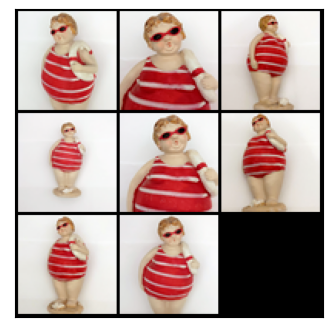

In [10]:
pic_res=(64,64)
imgs,PILimgs=load_imgs(imgs_path,pic_res,flip=False)
if_I.show(PILimgs, size=4)

## Learn an embedding (for a single T5 token)

In [11]:
learn="my" # has to be a word with a single token, don't use punctation-characters (*/#/...), since those filtered away in the standard dream pipeline (bad_punct_regex)
start="fat" # word with single token or "randn_like"
negative_prompt="deformed, ugly, disfigured, blurry, pixelated, hideous, indistinct, old, malformed, extra hands, extra arms, joined misshapen, collage, grainy, low, poor, monochrome, huge, extra fingers, mutated hands, cropped off, out of frame, poorly drawn hands, mutated hands, fused fingers, too many fingers, fused finger, closed eyes, cropped face, blur, long body, people, watermark, text, logo, signature, text, logo, writing, heading, no text, logo, wordmark, writing, heading, signature, 2 heads, 2 faces, b&w, nude, naked"
style_prompt="photo"
learning_rates=[(50,0.5),(100,0.4),(200,0.3),(500,0.2),(2000,0.1)]
# "{}"-gaps in the prompts will be learned 
prompts_for_objects=["a SLR photo of a {}","a photo of a {}","a rendering of a {}","a cropped photo of a {}","the rendering of a {}","a photo of a small {}","a photo of a fat {}","a rendering of a dirty {}","a dark photo of the {}","a rendering of a big {}","a 3D rendering of a {}","a close-up photo of a {}","a bright photo of the {}","a cropped photo of a {}","a rendering of the {}","an award winning photo of a {}","a photo of one {}","a close-up photo of the {}","a photo of the clean {}","a rendering of a nice {}","a good photo of a {}","a full body photo of a cute {}","a 3D rendering of the small {}","a photo of the weird {}","a photo of the large {}","a rendering of a cool {}","a SLR photo of a small {}"]
prompts_for_faces=["a SLR photo of {}","a photo of {}","a studio photo of {}","a cropped photo of {}","a close-up photo of {}","an award winning photo of {}","a good photo of {}","a portrait photo of {}","a SLR photo of a cool {}","a SLR photo of the face of {}","a funny portrait of {}"]
prompts_for_styles=["a face in {} style","a portrait, {}","A {} portrait","{} showing a face","a portrait of a person depicted in a {}","{} showing a person","in style of {}","person ,{} style"]
# "{my ...}" will be combined with all prompt_variations
object_variations=["figure, white background","woman, white background","doll, white background","puppet, white background"]
face_variations=[", white background"]
style_variations=["acryl","painting","art","picture"]

In [12]:
#OBJECT
progression=t5_textual_inversion(t5,if_I,imgs=imgs,prompts=prompts_for_objects,token=learn,start_token=start,token_variations=object_variations,negative_prompt=None,style_prompt=style_prompt,learning_rates=learning_rates) 

#FACE
#progression=t5_textual_inversion(t5,if_I,imgs=imgs,prompts=prompts_for_faces,token=learn,start_token=start,token_variations=None,negative_prompt=negative_prompt,style_prompt=style_prompt,learning_rates=learning_rates) 
#OBJECT
#progression=t5_textual_inversion(t5,if_I,imgs=imgs,prompts=prompts_for_objects,token=learn,start_token=start,token_variations=object_variations,negative_prompt=None,style_prompt=style_prompt,learning_rates=learning_rates) 
#STYLE
#progression=t5_textual_inversion(t5,if_I,imgs=imgs,prompts=prompts_for_styles,token=learn,start_token="colorful",token_variations=style_variations,negative_prompt=None,style_prompt="acryl painting",learning_rates=learning_rates) 

# save final embedding from progression list
save_embedding(progression[-1],"myPuppet.pt",path=embs_path)

my (fat) ['figure, white background', 'woman, white background', 'doll, white background', 'puppet, white background']


[-##.### (#.###) +##.###] lr=#.####::   0%|          | 0/11400 [00:00<?, ?it/s]

## Generate images from learned embedding in the standard DeepFloyd IF dream pipeline
* To apply learned and saved embeddings in your dream pipeline, use the set/load_embedding functions below.
* In this notebook stage_I is used for control purposes only (and to fit everything within 24 GB of CUDA memory).
* The learned t5 embeddings work with all three IF stages!
*   BUT you have to use the same stage_I model for learning and generating!
* You can redefine any single token word with the learned embedding. E.g. "my" or "me" are self-explanatory.
*   BUT don't use "*" in stable diffusion style, since punctation is filtered away in DeepFloyd IF!

In [13]:
# copy these functions into your DeepFloyd IF dream pipeline

def set_embedding(t5,emb,word="my"):
    with torch.no_grad():
        tokens=t5.tokenizer(word,max_length=77,padding='max_length',truncation=True,return_attention_mask=False,add_special_tokens=True,return_tensors='pt')
        assert tokens['input_ids'][0][1]==1, 'word is more than one token'
        tokenNo=tokens['input_ids'][0][0]
        assert t5.model.shared.weight[tokenNo].shape==emb.shape, 'wrong dimension of embedding'
        t5.model.shared.weight[tokenNo]=emb.to(t5.device)

def load_embedding(t5,word="my",embedding_file="myToken.pt",no=0,path="./Embeddings/"):
    emb=torch.load(path+embedding_file)
    set_embedding(t5,emb,word)

learned="my"
load_embedding(t5,learned,"myPuppet.pt",path=embs_path)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

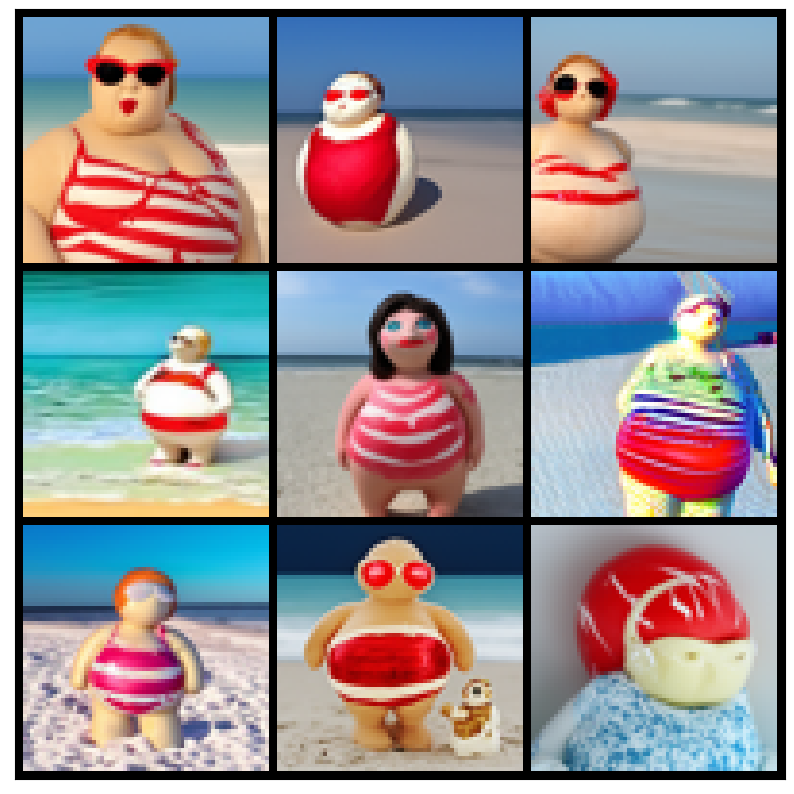

In [17]:
prompt="a photo of {} doll at the beach".format(learned)    
negative_prompt=None #"deformed, ugly, disfigured, blurry, pixelated, hideous, indistinct, old, malformed, extra hands, extra arms, joined misshapen, collage, grainy, low, poor, monochrome, huge, extra fingers, mutated hands, cropped off, out of frame, poorly drawn hands, mutated hands, fused fingers, too many fingers, fused finger, closed eyes, cropped face, blur, long body, people, watermark, text, logo, signature, text, logo, writing, heading, no text, logo, wordmark, writing, heading, signature, 2 heads, 2 faces, b&w, nude, naked"
style_prompt=None #"photo"
count=1
seed=2
results=list()
for seed in range(10,19):
    result = dream(
        t5=t5, if_I=if_I, if_II=None, if_III=None,
        prompt=[prompt]*count,
        style_prompt=[style_prompt]*count if style_prompt else None,
        negative_prompt=[negative_prompt]*count if negative_prompt else None,
        seed=seed,
        aspect_ratio='1:1',
        if_I_kwargs={
            "guidance_scale": 4.0,
            "sample_timestep_respacing": "smart100",
        }
    )
    results.append(result["I"][0])

if_I.show(results)